In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import math
from itertools import product
from glob import glob
import os
from itertools import cycle

# First pass, are there interesting daily patterns in biking behavior?
## Data not included
Grabbed data from citibike urls, have to add data retrieval steps, consult https://github.com/toddwschneider/nyc-citibike-data

### Cheated with speed and distance. I just comput distance and speed by adding together change in Latitude to the Change in Longitude.  

In [115]:
def readCSV(csv):
    d = pd.read_csv(csv,
                parse_dates = ['starttime','stoptime'],
                infer_datetime_format = True)
    d.columns = ['tripdur','st','et','ssid','ssname','sslat','sslon',
            'esid','esname','eslat','eslon','bikeid','usertype','yob','gender']
    d['age'] = d['st'].apply(lambda x: x.year) - d.yob
    # convert from degrees to miles, 
    d['ns'] = (d.eslat - d.sslat)*69.172
    # the distance of longitudintal degrees vary with latidute, employ a quick transformation.
    d['ew'] = (d.eslon - d.sslon)*(math.cos(40.7648 *(math.pi/180)) * 69.172)
    d['psuedospeed'] = (d.ns.abs()+d.ew.abs()) / (d.tripdur/3600)
    d['psuedodistance'] = d.ns.abs()+d.ew.abs()
    # break start and stop times into 5 minute intervals
    ns5min=5*60*1000000000   # 5 minutes in nanoseconds 
    d['st5min'] = pd.to_datetime(((d.st.astype(np.int64) // ns5min + 1 ) * ns5min))
    d['et5min'] = pd.to_datetime(((d.et.astype(np.int64) // ns5min + 1 ) * ns5min))
    ns10min=10*60*1000000000   # 5 minutes in nanoseconds 
    d['st10min'] = pd.to_datetime(((d.st.astype(np.int64) // ns10min + 1 ) * ns10min))
    d['et10min'] = pd.to_datetime(((d.et.astype(np.int64) // ns10min + 1 ) * ns10min))
    return d


In [253]:
# we have som garbage in here
# had used glob, but order was not sorted or fixed, so do this:
csvpaths = [os.path.join(os.pardir,'data',"2015%02d-citibike-tripdata.csv" % m) for m in np.arange(12)+1]
t = np.zeros((int(60*24/10),12))
spd = np.copy(t)
dist = np.copy(t)
dur = np.copy(t)
cnts = np.copy(t)
for i,csv in enumerate(csvpaths):
    print(csv)
    d = readCSV(csv)
    grp = d.groupby(by=[d.st10min.map(lambda x : int(x.hour*60 + x.minute))])
    x = pd.to_timedelta(grp.psuedodistance.mean().index.values/60, unit='m')
    t[:,i] = x
    cnts[:,i] = grp.tripdur.size()
    spd[:,i] = grp.psuedospeed.mean()
    dist[:,i] = grp.psuedodistance.mean()
    dur[:,i] = grp.tripdur.mean()/60 # do trip duration in minutes.


..\data\201501-citibike-tripdata.csv
..\data\201502-citibike-tripdata.csv
..\data\201503-citibike-tripdata.csv
..\data\201504-citibike-tripdata.csv
..\data\201505-citibike-tripdata.csv
..\data\201506-citibike-tripdata.csv
..\data\201507-citibike-tripdata.csv
..\data\201508-citibike-tripdata.csv
..\data\201509-citibike-tripdata.csv
..\data\201510-citibike-tripdata.csv
..\data\201511-citibike-tripdata.csv
..\data\201512-citibike-tripdata.csv


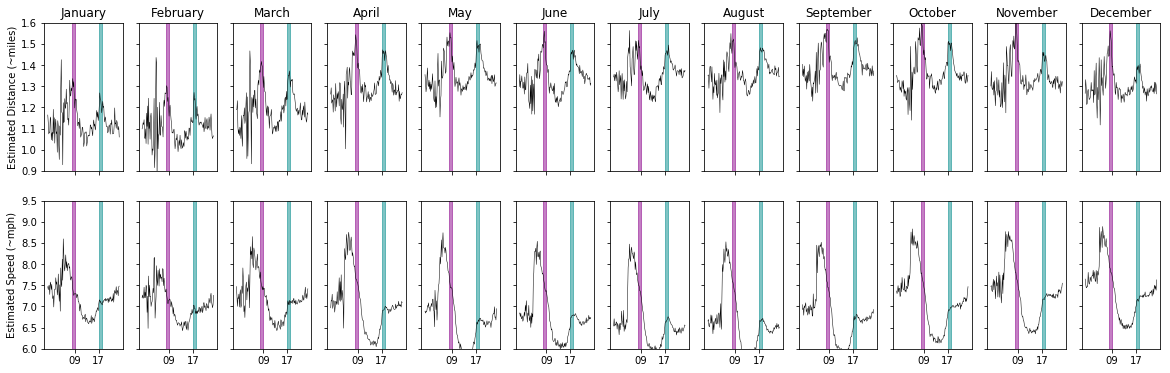

In [259]:
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import calendar
# we have som garbage in here
def timeTicks(x, pos): 
    d = datetime.timedelta(milliseconds=x/1000000)                                                                                                                                                                                                                                          
    return str(d)[2:4]                                                                                                                                                                                                                                                             
formatter = mpl.ticker.FuncFormatter(timeTicks) 

f, axar = plt.subplots(2,len(csvpaths), sharey='row', sharex='col')
for i,csv in enumerate(csvpaths):
    axar[0,i].plot(x,dist[:,i],'-k',linewidth=0.5)
    axar[1,i].plot(x,spd[:,i],'-k',linewidth=0.5)
    axar[0,i].set_title(calendar.month_name[i+1])
    
for ax in axar.flatten():
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    amrush = 8*60*10**9
    pmrush = 17*60*10**9
    amrect = patches.Rectangle((amrush,0), width=60*10**9, height=1,
                         transform=trans, color='darkmagenta',
                         alpha=0.5)
    pmrect = patches.Rectangle((pmrush,0), width=60*10**9, height=1,
                         transform=trans, color='darkcyan',
                         alpha=0.5)
    [ax.add_patch(rect) for rect in [amrect,pmrect]]
    axar[0,i]
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_ticks([9*60*10**9,17*60*10**9])
    ax.set_title
axar[0,0].set_ylabel("Estimated Distance (~miles)")
axar[1,0].set_ylabel("Estimated Speed (~mph)")
[ax.set_ylim(0.9,1.6) for ax in axar[0,:]]
[ax.set_ylim(6,9.5) for ax in axar[1,:]]    
f.set_size_inches(20,6)
f.savefig('CartesianDistance.pdf')

You can see that there are peaks in the distance traveled around the beginning (magenta) and the end (cyan) of the work day (top row). Interestingly, there is a not a cooresponding pattern in the speed of travel about the work day. There is a clear peak in speed before the beginining of work, and a substantial slowing in the middle of the day. At the end of the work day, trips are faster than in the middle of the day, but not nearly as fast as in the morning. This pattern is observed throughout the year, but is more pronounced in the summer months, indicating a interaction with temperature (I am considering time of day as a proxy for temperature)

If individuals are riding more slowly on their return commute, then trip duration should dilate at the end of the day. Trips in the system have a 45 minute time limit though, and it would be interesting to see if the tendency to go slower at the end of the day, especially in the summer, runs into a penalty for taking too long. We could compare the distributions of durations for trips starting during the AM rush hour to those starting during the PM rush hour, maybe there is an obvious difference?

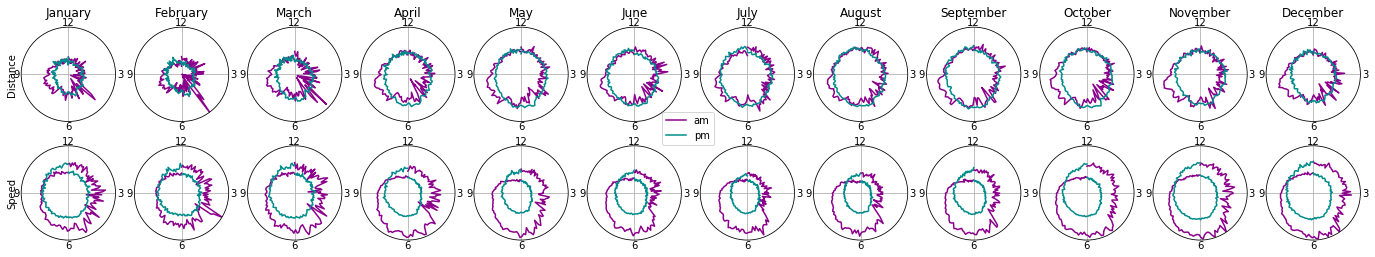

In [371]:
f, axar = plt.subplots(2,len(csvpaths), subplot_kw=dict(projection='polar'))
st,m,e = (0,int((24*60/5)//2), int((24*60/5)))
tm = np.linspace(2.5*np.pi,0.5*np.pi,int((24*60/5)//2))
labels={'darkmagenta':'am',
       'darkcyan':'pm'}
for i,csv in enumerate(csvpaths):
    for s, col in zip([slice(st,m),slice(m,e)],['darkmagenta','darkcyan']):
        axar[0,i].plot(tm,dist[:,i][s],color = col,label = labels[col])
        axar[1,i].plot(tm,spd[:,i][s],color = col)
        axar[0,i].set_title(calendar.month_name[i+1])
        
[ax.set_xticks([0,np.pi/2,np.pi,np.pi*3/2]) for ax in axar.flatten()]
[ax.set_xticklabels([3,12,9,6]) for ax in axar.flatten()]
[ax.set_rticks([]) for ax in axar.flatten()]
[ax.set_rlim(0.8,1.8) for ax in axar[0,:]]
[ax.set_rlim(5,9) for ax in axar[1,:]]
axar[0,0].set_ylabel('Distance')
axar[1,0].set_ylabel('Speed')
h,l = axar[0,0].get_legend_handles_labels()
f.legend(h,l,'center')
#[ax.set_ylim(0.8,1.6) for ax in axar[0,:]]
#[ax.xaxis.set_ticks([9*60*10**9,17*60*10**9]) for ax in axar.flatten()]
f.set_size_inches(24,4)
f.savefig('PolarDistance.pdf')

## Saw something interesting! Riders go fast in AM commute, slow on the way home.
### New Question: Does riders respond to poor air quality? 
The AM commute and PM commute are much different, would be interested to see t
### GOAL: a NLS regression model to see whether air quality impacts riding behavior. 

In [117]:
air = pd.read_csv(os.path.join(os.pardir,'data','AQDM.txt'),
                parse_dates = [['Date Local','24 Hour Local']],
                usecols = [6, 7, 9, 10, 11,16,17],
                dtype = {'Site Num':str},
                infer_datetime_format=True,
                skipfooter = 1)
air.rename(columns={'Date Local_24 Hour Local':'DateTime'},inplace = True)

C:\Users\Matthew Perkins\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


The existence of negative PM 2.5 densities is a bit troubling for PS19 and Division Street, may have to examine what measurement procedure produces these negative values?

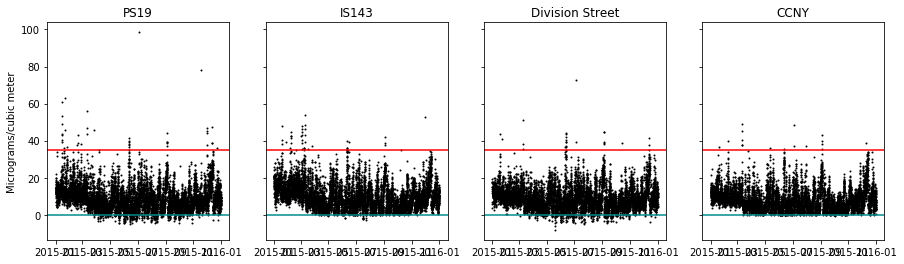

In [208]:
f, axar = plt.subplots(1,4,sharey='row')
sites = tuple(zip(['0128','0115','0134','0135'],
                ['PS19','IS143','Division Street','CCNY']))
for i, (Site, Desc) in enumerate(sites):
    tmpd = air[(air['Site Num']==Site) & (air['Parameter Code']==88502)]
    axar[i].plot(tmpd.DateTime, tmpd['Sample Measurement'],'.k',markersize = 2)
    axar[i].axhline(35,color = 'red')
    axar[i].axhline(0,color = 'darkcyan')
    axar[i].set_title(Desc)
axar[0].set_ylabel('Micrograms/cubic meter')
f.set_size_inches(15,4)


Intermediate School 143 is the monitoring site with the most observations with exceeding the EPA PM 2.5 limit? (35 Micrograms/cubic meter), city college of New York, up in harlem is doing better.

Would like to see to what degree the measurements between different stations concord

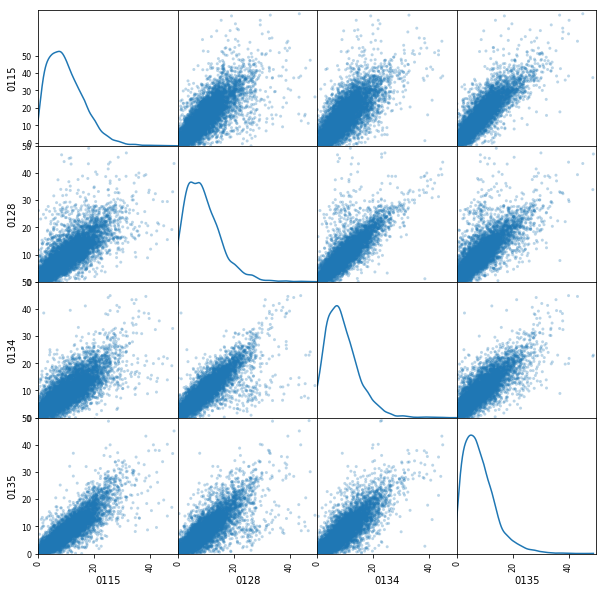

In [242]:
PM25 = air[air['Parameter Code']==88502]
PM25 = PM25.pivot(index='DateTime', columns = 'Site Num')['Sample Measurement']
from pandas.plotting import scatter_matrix
axar = scatter_matrix(PM25,diagonal = 'kde',figsize = (10,10), alpha = 0.3)
for ax in axar.flatten():
    ax.set_ylim(0,50)
    ax.set_xlim(0,50)
for ax in axar.diagonal():
    ax.set_ylim(0,0.09)


Sites PS 19 and IS 143 definetly look like they are dirtier than Division street and CCNY.

In [186]:
air[air['Parameter Code']==88502].groupby(['Site Num'])['Sample Measurement'].apply(lambda x: np.sum(x>35))

Site Num
0115    37
0128    41
0134    24
0135    17
Name: Sample Measurement, dtype: int64

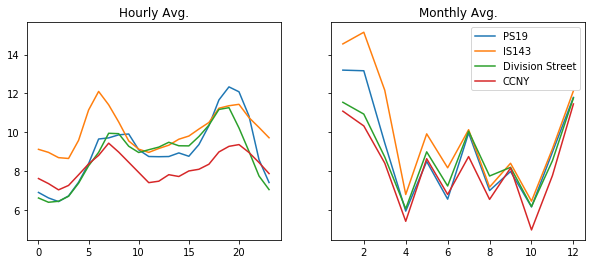

In [229]:
plt.figure()
hrly = air.groupby(by = ['Site Num','Parameter Code',air.DateTime.map(lambda x: x.hour)])['Sample Measurement'].mean()
mnthly = air.groupby(by = ['Site Num','Parameter Code',air.DateTime.map(lambda x: x.month)])['Sample Measurement'].mean()
f, axar = plt.subplots(1,2,sharey='row')
for (Site, Descr) in sites:
    axar[0].plot(hrly.xs([Site,88502]).index,
             hrly.xs([Site,88502]).values,
             label = Descr)
    axar[1].plot(mnthly.xs([Site,88502]).index,
             mnthly.xs([Site,88502]).values,
             label = Descr)
axar[0].set_title('Hourly Avg.')
axar[1].set_title('Monthly Avg.')
f.set_size_inches(10,4)
plt.gca().legend()

It looks like PM2.5 concentrations are MUCH higher in the winter, and have a bump during rush hour. I blame low grade fuel oil for the winter bump. 

CCNY monitering site also has measures of Ozone and Carbon Monoxide, would like to compare this patterns to PM2.5.
Ozone has an obviously different pattern through out the day.

In [275]:
mnthly


Site Num  Parameter Code  DateTime
0115      88502           1           14.550949
                          2           15.153293
                          3           12.158187
                          4            6.783838
                          5            9.910653
                          6            8.159764
                          7           10.125601
                          8            7.164216
                          9            8.392943
                          10           6.437571
                          11           9.143277
                          12          12.130299
0128      88502           1           13.199057
                          2           13.166168
                          3            9.438089
                          4            5.925289
                          5            8.487027
                          6            6.542877
                          7            9.956081
                          8            6.985714
     

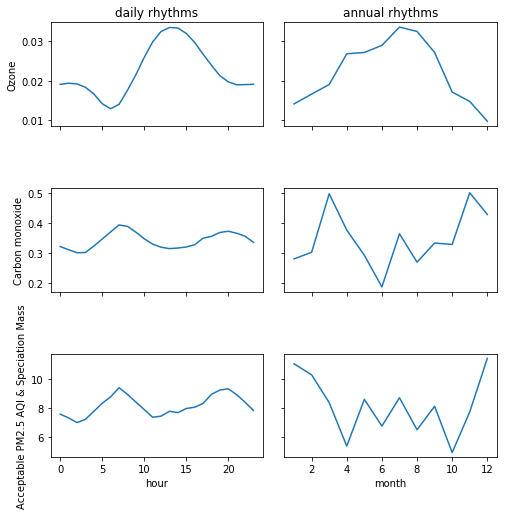

In [291]:
hrly = air.groupby(by = ['Site Num','Parameter Code',air.DateTime.map(lambda x: x.hour)])['Sample Measurement'].mean()
f, axar = plt.subplots(3,2,gridspec_kw = {'wspace':0.1,'hspace':0.6},sharex='col',sharey='row')
Codes = zip(air['Parameter Code'].unique(),air['AQS Parameter Desc'].unique())
for i, (Code, Desc) in enumerate(Codes):
    axar[i,0].plot(hrly.xs(['0135',Code]).index,
             hrly.xs(['0135',Code]).values,
             label = Desc)
    axar[i,1].plot(mnthly.xs(['0135',Code]).index,
             mnthly.xs(['0135',Code]).values,
             label = Desc)
    axar[i,0].set_ylabel(Desc)
axar[-1,0].set_xlabel('hour')
axar[-1,1].set_xlabel('month')
axar[0,0].set_title('daily rhythms')
axar[0,1].set_title('annual rhythms')
f.set_size_inches((8,8))


Ozone probably roughly tracks temperature, on a daily and annual rhythm. This could make it difficult to assess whether it has an impact on riding behavior independent of temperature.

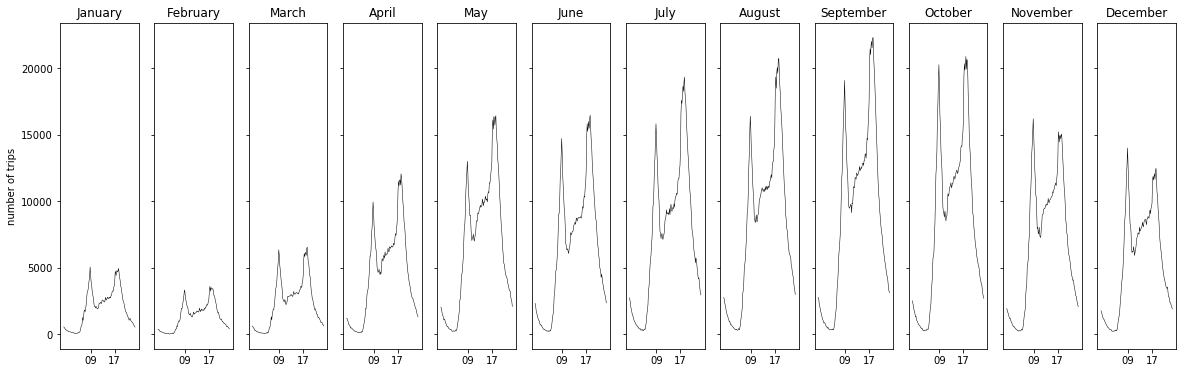

In [272]:
f, axar = plt.subplots(1,len(csvpaths), sharey='row', sharex='col')
for i,csv in enumerate(csvpaths):
    axar[i].plot(x,cnts[:,i],'-k',linewidth=0.5)
    axar[i].set_title(calendar.month_name[i+1])
    
for ax in axar.flatten():
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    amrush = 8*60*10**9
    pmrush = 17*60*10**9
    amrect = patches.Rectangle((amrush,0), width=60*10**9, height=1,
                         transform=trans, color='darkmagenta',
                         alpha=0.5)
    pmrect = patches.Rectangle((pmrush,0), width=60*10**9, height=1,
                         transform=trans, color='darkcyan',
                         alpha=0.5)
    #[ax.add_patch(rect) for rect in [amrect,pmrect]]
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_ticks([9*60*10**9,17*60*10**9])
axar[0].set_ylabel("number of trips")
f.set_size_inches(20,6)
f.savefig('NumTrips.pdf')